<a href="https://colab.research.google.com/github/DotunOluyade/ShootingVideoClassifier/blob/main/VideoAnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Real-Time Crime Prevention using Video Anomaly Detection




Comparative Analysis of Pretrained Video Classification models in detecting real-time shooting crime for peace and safety

## Data Collection

A sub-set of UCF-Crime dataset is used for this research work. It contains 128 hours of video, comprising 1900 long untrimmed real world surveillance videos, with 13 realistic anomalies as well as normal activities (Sultani et al., *2018*).

This research uses the shooting dataset only to fine-tune selected video classification pretrained models, compares and evaluate their performance.

### Specify Dataset Location

Import package dependencies and define variables for datasets and pretrained model.

Video Swim a pure transformer based video modeling algorithm with its pretrained model is used for feature extraction and fine-tuned with the shooting dataset for classifying videos as shooting or non shooting videos (Liu et al.,2022).



In [1]:
import cv2
import os
import shutil
import pandas as pd
import shutil
import numpy as np
from sklearn.utils import shuffle as sk_shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import os
import glob
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from IPython.display import HTML, display



base_directory = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/'
normal_dir = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Normal_Videos'
anomaly_dir = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting'
anomaly_text_file = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Anomaly_Train.txt'
anomaly_train = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/UCF_Crimes-Train-Test-Split/Anomaly_Detection_splits/Anomaly_Train.txt'

saved_model_path = '/content/drive/MyDrive/VideoAnomalyDetection/pretrained/Video Swin Transformer/TFVideoSwinB_K600_IN22K_P244_W877_32x224'

# Descriptive Statistics

In [2]:
training_data = pd.read_csv(anomaly_train, header=None, names=['Record'])


#shooting_videos = data[data['Record'].str.contains('Shooting')]
#normal_videos = data[data['Record'].str.contains('Training_Normal_Videos_Anomaly')]

#print("\nShooting videos: ", shooting_videos.describe())
#print("\nNormal videos: ", normal_videos.describe())
print("\nTraining videos: ", training_data.describe())


# Construct the absolute paths
training_data['Absolute_Path'] = base_directory + training_data['Record']


# Placeholder list to hold video HTML strings
videos_html = []

# Loop through the DataFrame and create video HTML strings
for video_path in training_data['Absolute_Path'].head(6):
    # Convert your Google Drive shared link to direct link here
    # For demonstration, using a direct link format directly
    direct_link = video_path.replace("/view?usp=sharing", "").replace("https://drive.google.com/file/d/", "https://drive.google.com/uc?export=view&id=")

    video_html = f"""
    <div style='flex: 33%; padding: 5px;'>
        <video width="100%" controls>
          <source src='{direct_link}' type="video/mp4">
          Your browser does not support the video tag.
        </video>
    </div>
    """
    videos_html.append(video_html)

# Wrap the videos in a flex container for a 3-column grid
grid_html = f"<div style='display: flex; flex-wrap: wrap;'>{''.join(videos_html)}</div>"

# Display the grid
display(HTML(grid_html))



# Split the 'Record' column on '/', take the first part, and perform a value count
category_counts = training_data['Record'].str.split('/').str[0].value_counts()

# Display the counts
print(category_counts)



Training videos:                                   Record
count                              1610
unique                             1610
top     Vandalism/Vandalism050_x264.mp4
freq                                  1


Training_Normal_Videos_Anomaly    800
Robbery                           145
RoadAccidents                     127
Stealing                           95
Burglary                           87
Abuse                              48
Assault                            47
Vandalism                          45
Arrest                             45
Fighting                           45
Arson                              41
Explosion                          29
Shoplifting                        29
Shooting                           27
Name: Record, dtype: int64


# Data Preprocessing

Resize, normalize and split videos into frames. Batch frames in 32 segments.

Use data generators to prevent loading large datset into memory at once, to better utilize memory for resource constrained environement.

Generator loads and preprocess 32 frames at each interval.

In [3]:
def preprocess_and_segment_video(video_path, resize_shape=(224, 224), segment_length=32):
    """
    Preprocess raw videos by resizing, color space conversion, normalization

    Parameters:
    - video_path: absolute path to video file
    - resize_shape: shape (224,224) to resize video to
    - segment_length: value to segment frames of video to

    Returns:
    - a batch of 32 preprocessed frames of shape (32, 224, 224, 3), using generators
    """
    def video_generator():
        cap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break  # Exit loop if video ends
            frame = cv2.resize(frame, resize_shape)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
            frames.append(frame)

            if len(frames) == segment_length:
                yield np.array(frames)
                frames = []

        # Handle the last segment if it has fewer frames than segment_length
        if frames:  # Check if there are remaining frames
            # Pad the last segment to have 'segment_length' frames
            padding = [np.zeros_like(frames[0]) for _ in range(segment_length - len(frames))]
            frames.extend(padding)
            yield np.array(frames)  # Yield the padded last segment
        cap.release()

    return tf.data.Dataset.from_generator(
        video_generator,
        output_signature=tf.TensorSpec(shape=(segment_length, *resize_shape, 3), dtype=tf.float32)
    )


### List and Shuffle Video files

In [4]:
"""
Note: Changed 'train_size' argument to 'train_size_ratio' to avoid confusion with the calculated 'train_size' variable.
"""
def list_video_files(directory, extension='*.mp4'):
    """
    List all video files in the given directory with the specified extension.

    Parameters:
    - directory: Path to the directory to search for video files.
    - extension: Extension of the video files to search for (default is '*.mp4').

    Returns:
    - A list of paths to the video files found.
    """
    # Create a full path pattern by joining directory and extension
    pattern = os.path.join(directory, extension)
    # Use glob to find all files matching the pattern
    video_files = glob.glob(pattern)

    return video_files


def shuffle_together(video_paths, label):
    """
    Shuffle two lists in unison.

    Parameters:
    - video_paths: The first list to shuffle.
    - label: The second list to shuffle, must be the same length as list1.

    Returns:
    - The shuffled video_paths and label.
    """
    if len(video_paths) != len(label):
        raise ValueError("The lists to be shuffled must be the same length.")

    # sklearn's shuffle function to shuffle both lists in unison
    video_paths_shuffled, label_shuffled = shuffle(video_paths, label)
    return video_paths_shuffled, label_shuffled


def create_dataset_from_videos(video_paths, labels, resize_shape=(224, 224), segment_length=32):
    """
    Creates a TensorFlow dataset of video segments with corresponding labels.

    Args:
        video_paths (list of str): Paths to video files.
        labels (list of int): Labels for each video file.
        resize_shape (tuple): The target shape for resizing frames.
        segment_length (int): Number of frames per video segment.

    Returns:
        tf.data.Dataset: A dataset of video segments and labels.
    """
    def generator():
        for video_path, label in zip(video_paths, labels):
            # Use preprocess_and_segment_video to yield segments
            for segment in preprocess_and_segment_video(video_path, resize_shape, segment_length):
                #visualize_preprocess_and_segment_video(segment,resize_shape,label,segment_length)
                yield segment.numpy(), label

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(segment_length, *resize_shape, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )

def get_video_duration(video_path):
    """
    Get the duration of a video in seconds.

    Parameters:
    - video_path: The file path to the video.

    Returns:
    - The duration of the video in seconds as a float.
    """
    # Initialize the video capture object
    cap = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get the frame rate of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Release the video capture object
    cap.release()

    # Calculate the duration
    duration = total_frames / fps if fps > 0 else 0

    return duration


def calculate_total_segments(video_paths, segment_length=32):
    total_segments = 0
    for video_path in video_paths:
        duration = get_video_duration(video_path)  # This function needs to be defined
        segments = duration // segment_length
        # If the video is not perfectly divisible by segment_length, consider the remainder as an additional segment
        if duration % segment_length != 0:
            segments += 1
        total_segments += segments
    return total_segments



# Assuming implementations for list_video_files and shuffle_together
anomaly_videos, normal_videos = list_video_files(anomaly_dir), list_video_files(normal_dir)
print("anomaly_videos", len(anomaly_videos))
print("normal_videos", len(normal_videos))

video_paths = anomaly_videos + normal_videos
labels = [1] * len(anomaly_videos) + [0] * len(normal_videos)

video_paths, labels = shuffle_together(video_paths, labels)

dataset = create_dataset_from_videos(video_paths, labels)

# calculate the total video segments
total_segments = int(calculate_total_segments(video_paths, segment_length=32))

print("Total segments: ", total_segments)

# Calculate split sizes
train_size = int(total_segments * 0.8)
val_size = total_segments - train_size  # Optionally, to ensure the entire dataset is used

# Ensure dataset is shuffled if needed (use actual total size if known for better shuffling)
# Note: This step requires substantial memory for large datasets; adjust buffer size as feasible
dataset = dataset.shuffle(buffer_size=total_segments)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)



anomaly_videos 30
normal_videos 27
Total segments:  172


In [20]:
import tempfile

def test_list_video_files():
    # Create a temporary directory
    with tempfile.TemporaryDirectory() as temp_dir:
        # Create dummy files
        video_filenames = ['video1.mp4', 'video2.mp4']
        non_video_filenames = ['image1.png', 'text1.txt']
        for filename in video_filenames + non_video_filenames:
            open(os.path.join(temp_dir, filename), 'a').close()

        # Call the function under test
        listed_files = list_video_files(temp_dir, '*.mp4')


        # Assert correctness
        assert len(listed_files) == len(video_filenames), "Incorrect number of video files listed."
        assert all(os.path.basename(file) in video_filenames for file in listed_files), "Listed files are not correct."

# You would call this test function in your test suite
test_list_video_files()


# Fine-Tune A Pretrained Video Swin Transformer Model for Video Classification

In [5]:
def build_finetune_model():
    """
    Fine tune pretrained model

    Returns:
        model (Fine-tuned for shooting classification)
    """
   # import pretrained model, i.e.
    video_swin = keras.models.load_model(saved_model_path, compile= False)
    video_swin.trainable = False

    # downstream model
    model = keras.Sequential([
        video_swin,
        # video_swin outputs a 1D tensor of shape (600,)
        layers.Dense(1024, activation='relu'),  # Additional Dense layer
        layers.Dropout(0.5),  # Dropout layer to reduce overfitting
        layers.Dense(1, activation='sigmoid')  # Final Dense layer for binary classification
    ])
    return model


#Train the Fine-Tuned Model for Shooting Classification

In [6]:
# Callbacks configuration
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks_list = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        verbose=1,
        save_best_only=True,
        monitor='val_loss'),  # Save the best model based on val_loss
    EarlyStopping(
        monitor='val_loss',
        patience=10),  # Stop training when `val_loss` is no longer improving
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5),  # Reduce learning rate when `val_loss` plateaus
    TensorBoard(
        log_dir='./logs',  # Path to save log files for TensorBoard
        histogram_freq=1,  # Record activation histograms every 1 epoch
        embeddings_freq=1)  # Record embedding data every 1 epoch
]

In [7]:
# Split into training and validation data
#train_dataset, val_dataset = create_train_val_datasets(anomaly_dir, normal_dir, train_size=0.8, shuffle_buffer_size=100)

# Batch for memory efficiency
batch_size = 1
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

# Check shapes of the dataset elements after batching
for x, y in train_dataset.take(1):
    print("Shape of x:", x.shape)
    print("Shape of y:", y.shape)

steps_per_epoch = total_segments // batch_size


# Asynchronously fetch batches while model is training
#train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
#val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Only use cache() if memory limits won't be exceeded
#train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
#val_dataset = val_dataset.cache().prefetch(tf.data.AUTOTUNE)


finetune_model = build_finetune_model()
# Compile model with binary entropy loss, adam optimizer and metrics
finetune_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Train the model
history = finetune_model.fit(train_dataset, epochs=10,steps_per_epoch=steps_per_epoch,
validation_data=val_dataset,callbacks=callbacks_list)


Shape of x: (1, 32, 224, 224, 3)
Shape of y: (1,)
Epoch 1/10
137/172 [======================>.......] - ETA: 6s - loss: 0.0484 - accuracy: 0.9927 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00

KeyboardInterrupt: 

# Evaluate Final Model Performance

NameError: name 'history' is not defined

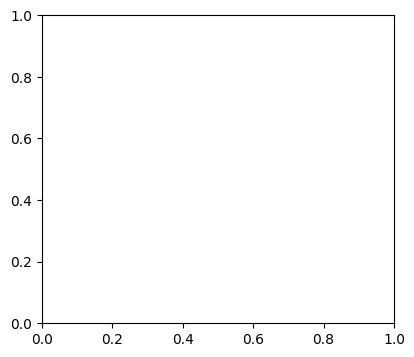

In [ ]:
# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot precision, recall, and AUC
plt.figure(figsize=(15, 5))

# Precision
plt.subplot(1, 3, 1)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision over epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(1, 3, 2)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall over epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC over epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate the model
#test_loss, test_accuracy, test_precision, test_recall, test_auc = finetune_model.evaluate(test_dataset)
#print(f"Test Metrics:\n Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, AUC: {test_auc}")

#References:

*   Sultani, W., Chen, C. and Shah, M., 2018. Real-world anomaly detection in surveillance videos. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Available at: https://www.crcv.ucf.edu/research/real-world-anomaly-detection-in-surveillance-videos/ 20/03/2024.
*   Liu, Z., Hu, H., Lin, Y., Yao, Z., Xie, Z., Wei, Y., Ning, J., Cao, Y., Zhang, Z., Dong, L. and Wei, F., 2022. Swin transformer v2: Scaling up capacity and resolution. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. Available at: https://github.com/innat/VideoSwin 20/03/2024
